In [1]:
import nest
import nest.raster_plot
from numpy import exp

In [2]:
def LambertWm1(x):
    nest.ll_api.sli_push(x)
    nest.ll_api.sli_run('LambertWm1')
    y = nest.ll_api.sli_pop()
    return y


def ComputePSPnorm(tauMem, CMem, tauSyn):
    a = (tauMem / tauSyn)
    b = (1.0 / tauSyn - 1.0 / tauMem)

    # time of maximum
    t_max = 1.0 / b * (-LambertWm1(-exp(-1.0 / a) / a) - 1.0 / a)

    # maximum of PSP for current of unit amplitude
    return (exp(1.0) / (tauSyn * CMem * b) *
            ((exp(-t_max / tauMem) - exp(-t_max / tauSyn)) / b -
             t_max * exp(-t_max / tauSyn)))


nest.ResetKernel()

In [3]:
dt = 0.1    # the resolution in ms
simtime = 500.0  # Simulation time in ms
delay = 1.5    # synaptic delay in ms

#### Weight, rate and connection probability

In [4]:
g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

#### Number of neurons in the network

In [5]:
order = 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI   # number of neurons in total
N_rec = 50      # record from 50 neurons

#### Connectivity parameters

In [6]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

#### Neuron parameters

In [7]:
tauSyn = 0.5  # synaptic time constant in ms
tauMem = 20.0  # time constant of membrane potential in ms
CMem = 250.0  # capacitance of membrane in in pF
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_ex": tauSyn,
                 "tau_syn_in": tauSyn,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1        # postsynaptic amplitude in mV
J_unit = ComputePSPnorm(tauMem, CMem, tauSyn)
J_ex = J / J_unit  # amplitude of excitatory postsynaptic current
J_in = -g * J_ex    # amplitude of inhibitory postsynaptic current

#### External rate

In [8]:
nu_th = (theta * CMem) / (J_ex * CE * exp(1) * tauMem * tauSyn)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

#### Configure simulation kernel

In [9]:
nest.SetKernelStatus({"resolution": dt,
                      "print_time": True,
                      "overwrite_files": True,
                      "total_num_virtual_procs": 4})

#### Create nodes

In [10]:
nodes_ex = nest.Create("iaf_psc_alpha", NE)
nodes_in = nest.Create("iaf_psc_alpha", NI)
nodes_ex.set(neuron_params)
nodes_in.set(neuron_params)

In [11]:
noise = nest.Create("poisson_generator")
noise.rate = p_rate  # same as noise.set({"rate": p_rate})

In [12]:
espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

espikes.set(label="brunel-py-ex", record_to="ascii")
ispikes.set(label="brunel-py-in", record_to="ascii")

#### Create connections

In [13]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

In [14]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

In [15]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

#### Simulate

In [16]:
nest.Simulate(simtime)

#### Get results

In [17]:
events_ex = espikes.n_events  # same as espikes.get("n_events") 
events_in = ispikes.n_events

In [18]:
num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

In [19]:
print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory events : {0}".format(events_ex))
print("Inhibitory events : {0}".format(events_in))

Brunel network simulation (Python)
Number of neurons : 12500
Number of synapses: 15637600
       Exitatory  : 12512500
       Inhibitory : 3125000
Excitatory events : 714
Inhibitory events : 719


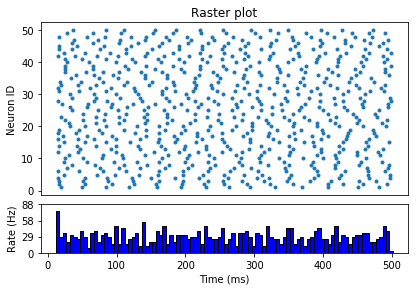

In [20]:
nest.raster_plot.from_device(espikes, hist=True)